In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
gs = pd.read_csv("annotated_BG_gold.tsv", delimiter = "\t", encoding = "utf-16le", usecols = [0,1,2,3,4,5], 
                names = ["ID", "Sentiment", "Speech", "Annotation", "Note", "2nd Annot"], dtype = object).dropna(subset = "Annotation")[:300]

In [3]:
gs.head()

,ID,Sentiment,Speech,Annotation,Note,2nd Annot
0,ParlaMint-BG_2022-07-14.u60,0.022931118447415487,Моята процедура е да бъде гледано на първо и в...,0,NaN,0
1,ParlaMint-BG_2016-06-09.u31,00.00,"Благодаря Ви , господин Александров . Реплики ...",0,NaN,0
2,ParlaMint-BG_2019-06-06.u100,0.07535767160197494,"Весело е , но е вярно . И аз се радвам . Радва...",2,NaN,2
3,ParlaMint-BG_2022-06-02.u180,0.08893593861412055,"Уважаеми господин Председател , уважаеми госпо...",1,NaN,-1
4,ParlaMint-BG_2014-12-12.u156,0.076745611756566,"Тоест на гладните отнемате коричката хляб , а ...",-1,NaN,-1


In [4]:
gs["Sentiment"] = gs["Sentiment"].astype(float)
gs["Annotation"] = gs["Annotation"].astype(float)
gs["2nd Annot"] = gs["2nd Annot"].astype(float)

In [5]:
gs["Annotation"].mean()

-0.18333333333333332

### Histograms

<AxesSubplot:>

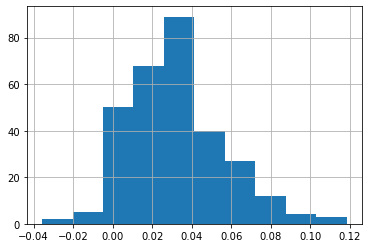

In [6]:
gs["Sentiment"].hist()

In [7]:
data = gs['Annotation'].value_counts().sort_index()

<AxesSubplot:>

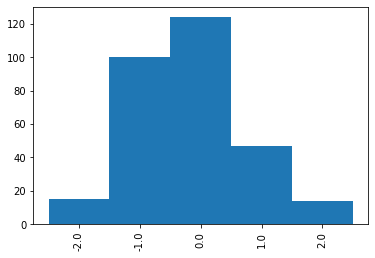

In [8]:
data.plot(kind='bar', width=1.0)

<AxesSubplot:>

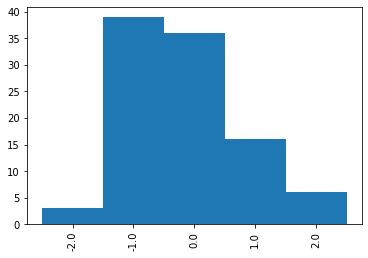

In [9]:
 gs["2nd Annot"].value_counts().sort_index().plot(kind = "bar", width = 1.0)

### Interannotator agreement

In [10]:
import sklearn
from sklearn.metrics import cohen_kappa_score

/Users/yananikolova/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
#fair/slight agreement
cohen_kappa_score(gs["Annotation"][:100], gs["2nd Annot"][:100])

0.7123957434570032

In [12]:
#how about with three categories?

negative = gs["Annotation"].isin([-2, -1])
positive = gs["Annotation"].isin([2, 1])
neutral = gs["Annotation"] == 0

gs["Minimal"] = pd.Series(dtype = float)
gs["Minimal"] = gs["Minimal"].mask(negative, other = -1)
gs["Minimal"] = gs["Minimal"].mask(positive, other = 1)
gs["Minimal"] = gs["Minimal"].mask(neutral, other = 0)

In [13]:
negative = gs["2nd Annot"].isin([-2, -1])
positive = gs["2nd Annot"].isin([2, 1])
neutral = gs["2nd Annot"] == 0

gs["2nd Minimal"] = pd.Series(dtype = float)
gs["2nd Minimal"] = gs["2nd Minimal"].mask(negative, other = -1)
gs["2nd Minimal"] = gs["2nd Minimal"].mask(positive, other = 1)
gs["2nd Minimal"] = gs["2nd Minimal"].mask(neutral, other = 0)

In [14]:
#fair/moderate agreement
cohen_kappa_score(gs["Minimal"][:100], gs["2nd Minimal"][:100])

0.7831474597273854

In [15]:
#confusion matrix 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(gs["Minimal"][:100], gs["2nd Minimal"][:100])


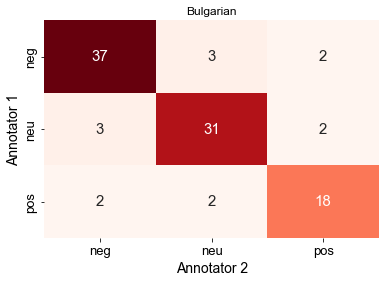

In [16]:
import seaborn as sns

ax= plt.subplot()
sns.set (rc = {'figure.figsize':(4,4)})
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Reds", cbar = False, annot_kws={"size": 15});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Annotator 2', fontsize = 14);
ax.set_ylabel('Annotator 1', fontsize = 14); 
ax.set_title('Bulgarian');
ax.xaxis.set_ticklabels(['neg', 'neu', 'pos'], fontsize = 13); 
ax.yaxis.set_ticklabels(['neg', 'neu', 'pos'], fontsize = 13);

## Correlation

In [17]:
from sklearn.feature_selection import r_regression

In [18]:
r_regression(gs["Annotation"].to_numpy().reshape(-1, 1), gs["Sentiment"])

array([0.40242303])

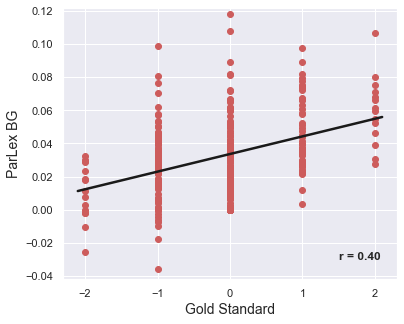

In [19]:
b, a = np.polyfit(gs["Annotation"], gs["Sentiment"], deg=1)
xseq = np.linspace(-2.1,2.1,50)
plt.rcParams["figure.figsize"] = (6,5)
plt.grid(zorder = -3.0)


plt.scatter(gs["Annotation"], gs["Sentiment"], color = "indianred", alpha = 1, zorder = 2.0)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.text(1.5, -0.03, "r = 0.40", fontsize = 12, weight = "bold")
plt.ylim(-0.042, 0.122)
plt.xlabel("Gold Standard", fontsize = 14)
plt.ylabel("ParLex BG", fontsize = 14)
#plt.title("Danish")
plt.show()

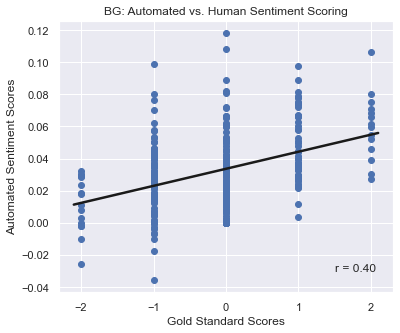

In [20]:
b, a = np.polyfit(gs["Annotation"], gs["Sentiment"], deg=1)
xseq = np.linspace(-2.1,2.1,50)

plt.scatter(gs["Annotation"], gs["Sentiment"])
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.text(1.5, -0.03, "r = 0.40", fontsize = 12)
plt.xlabel("Gold Standard Scores")
plt.ylabel("Automated Sentiment Scores")
plt.title("BG: Automated vs. Human Sentiment Scoring")
plt.show()

In [26]:
gs.groupby(["Annotation"])["Sentiment"].mean()

Annotation
-2.0    0.010755
-1.0    0.026273
 0.0    0.029376
 1.0    0.047315
 2.0    0.059855
Name: Sentiment, dtype: float64

In [27]:
r_regression(gs[~(gs["Note"] == "sarcasm")]["Annotation"].to_numpy().reshape(-1, 1), gs[~(gs["Note"] == "sarcasm")]["Sentiment"])

array([0.41031102])

In [28]:
(gs["Note"] == "sarcasm").sum()

9

In [29]:
8/300

0.02666666666666667

## Comparison to other lexicon

In [45]:
plt.rcdefaults()

In [46]:
pos_bg = pd.read_csv("positive_bg.csv", delimiter = ",", names = ["Word"], encoding = "utf-8", dtype = "str")["Word"].to_list()
neg_bg = pd.read_csv("negative_bg.csv", delimiter = ",", names = ["Word"], encoding = "utf-8",  dtype = "str")["Word"].to_list()


In [47]:
negwords = ["няма", "никога", "никой", "не"]
punct = [".", ",", "?", "!"]
skip = False
scores = []
for speech in gs["Speech"]:
    speech = [word.lower() for word in speech.split(" ")]
    score = 0
    for word in speech:
        if word in negwords:
            skip = True
        elif word in punct:
            skip = False
            
        if skip == False:
            if word in pos_bg:
                score += 1
            elif word in neg_bg:
                score += -1
    scores.append(score)
    

In [48]:
gs["Other"] = scores

<AxesSubplot:>

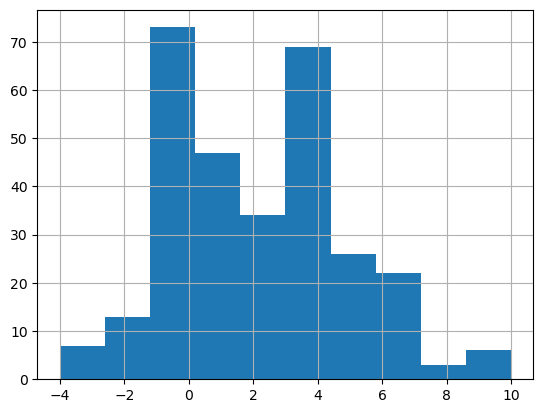

In [49]:
gs["Other"].hist()

In [50]:
r_regression(gs["Sentiment"].to_numpy().reshape(-1, 1), gs["Other"])

array([0.18545933])

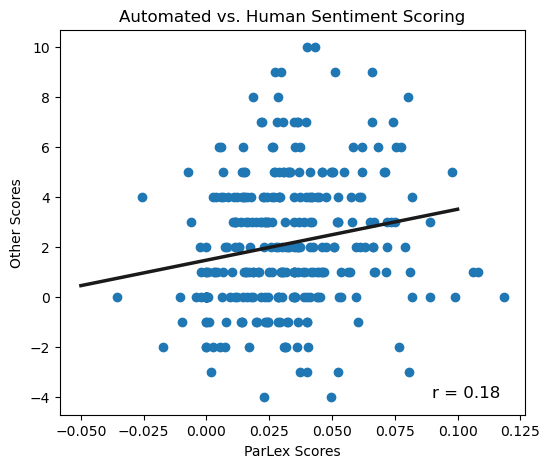

In [53]:
b, a = np.polyfit(gs["Annotation"], gs["Sentiment"], deg=1)
xseq = np.linspace(-2.1,2.1,50)
plt.rcParams["figure.figsize"] = (6,5)


plt.scatter(gs["Annotation"], gs["Sentiment"], color = "indianred", alpha = 1, zorder = 2.0)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.text(1.5, -0.03, "r = 0.40", fontsize = 12, weight = "bold")
plt.ylim(-0.042, 0.122)
plt.xlabel("Gold Standard", fontsize = 14)
plt.ylabel("ParLex BG", fontsize = 14)
#plt.title("Danish")
plt.show()



b, a = np.polyfit(gs["Sentiment"], gs["Other"], deg=1)
xseq = np.linspace(-0.05, 0.1,50)
plt.rcParams["figure.figsize"] = (6,5)



plt.scatter(gs["Sentiment"], gs["Other"], color = "indianred", alpha = 1, zorder = 2.0)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.text(0.09,-4, "r = 0.18", fontsize = 12, weight = "bold")
plt.xlabel("ParLex Scores")
plt.ylabel("Other Scores")
plt.title("Automated vs. Human Sentiment Scoring")
plt.show()

In [36]:
r_regression(gs["Annotation"].to_numpy().reshape(-1, 1), gs["Other"])

array([0.3486454])

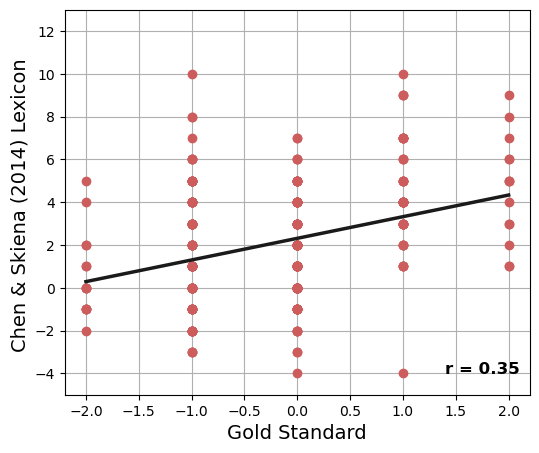

In [70]:

plt.rcParams["figure.figsize"] = (6,5)


b, a = np.polyfit(gs["Annotation"], gs["Other"], deg=1)
xseq = np.linspace(-2, 2,50)
plt.grid(zorder = -3.0)


plt.scatter(gs["Annotation"], gs["Other"], color = "indianred", alpha = 1, zorder = 2.0)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.text(1.4, -4,"r = 0.35",fontsize = 12, weight = "bold")
plt.ylim(-5,13)
plt.xlabel("Gold Standard", fontsize = 14)
plt.ylabel("Chen & Skiena (2014) Lexicon ", fontsize =14)
plt.show()

### Overlap

In [38]:
import classla
nlp = classla.Pipeline('bg', processors='tokenize, pos, lemma', tokenize_pretokenized = True)


2023-05-17 16:43:53 INFO: Loading these models for language: bg (Bulgarian):
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |

2023-05-17 16:43:53 INFO: Use device: cpu
2023-05-17 16:43:53 INFO: Loading: tokenize
2023-05-17 16:43:53 INFO: Loading: pos
2023-05-17 16:43:54 INFO: Loading: lemma
2023-05-17 16:43:55 INFO: Done loading processors!


In [39]:
doc = nlp(" ".join(pos_bg + neg_bg))

In [40]:
tokens = []
lemmas = []
pos = []

for word in doc.to_dict()[0][0]:
    tokens.append(word['text'])
    try:
        lemmas.append(word['lemma'])
        pos.append(word['upos'])
    except:
        lemmas.append(word['text'])
        pos.append("UNK")

In [41]:
lemmas = list(set(lemmas))

In [42]:
len(lemmas)

2585

In [43]:
with open('sentdict_pos_BG.txt', 'r') as f:
    poslist = [el.split('\t') for el in f.readlines()]
    
with open('sentdict_neg_BG.txt', 'r') as f:
    neglist = [el.split('\t') for el in f.readlines()]

#aggregate sentiment words and their scores
words = [line[0]for line in poslist] + [line[0] for line in neglist]


In [44]:
len(words) + len(lemmas)

3985

In [45]:
len(set(words+list(lemmas)))

3430

In [46]:
(3985-3430) 

555

In [47]:
1 - 3430/3985

0.13927227101631112

In [48]:
for lemma in lemmas:
    for word in words:
        if lemma == word:
            print(lemma)

конструктивен
възстановя-(се)
измамник
мъчителен
заблуждение
прозрачен
професионалист
отговорен
обвинение
налагам-(се)
красота
твърдение
дупка
помагам
получа
получа
неравенство
весел
успявам
отговарям
отговарям
сътрудничество
разочарование
ефикасен
остарея
остарея
враг
проблем
подчертая
мотивирам-(се)
дефект
съгласие
щастие
срам
лоялен
болезнен
инат
полза
скандален
заплаха
заразя-(се)
привързаност
зараза
избегна
леко
неправилен
геноцид
отклонение
доведа
противоречив
нежелан
освобождение
несъвместимост
първо
чист
принос
увереност
хроничен
осигуряване
изкривяване
съвършен
осъществяване
работя
работя
злоба
чест
чест
пропаст
остана
провокация
годен
тревожен
свободен
несигурност
конфронтация
симпатия
умирам
стимулиране
открит
падане
болен
постигане
виновен
неуспех
абсурден
инфекция
престъпник
мъдър
неприятен
готов
страдание
достоен
щастлив
желая
сигурен
катастрофа
суров
отчаяние
авария
повиша-(се)
готовност
поздрав
спор
затваряне
отпразнувам
обич
свобода
каша
изискам
патриотичен
криминален


### Do averages match?

In [21]:
df_dk = pd.read_csv("ParlaMint-BG-SENT.csv", delimiter = ",", dtype = object)
df_dk = df_dk[df_dk["Speaker_role"]!= "Chairperson"]
df_dk = df_dk.drop(df_dk[(df_dk["Speaker_Minister"] == "-") & (df_dk["Speaker_MP"] == "notMP")].index)

In [22]:
gs_full = gs.set_index("ID").merge(df_dk.set_index("ID"), on = "ID", how = "left")

In [23]:
gs_full.groupby(["Party_status"])["Sentiment_x"].mean()

Party_status
Coalition     0.034211
Opposition    0.030600
Name: Sentiment_x, dtype: float64

In [24]:
gs_full.groupby(["Party_status"])["Annotation"].mean()

Party_status
Coalition    -0.017544
Opposition   -0.258993
Name: Annotation, dtype: float64

In [38]:
coal = gs_full[gs_full["Party_status"] == "Coalition"]["Annotation"]
oppo = gs_full[gs_full["Party_status"] == "Opposition"]["Annotation"]

from scipy import stats
stats.ttest_ind(coal, oppo)

Ttest_indResult(statistic=2.0958574175227027, pvalue=0.03709660473213197)

Ttest_indResult(statistic=2.0958574175227027, pvalue=0.03709660473213197)

In [36]:
coal = gs_full[gs_full["Party_status"] == "Coalition"]["Sentiment_x"]
oppo = gs_full[gs_full["Party_status"] == "Opposition"]["Sentiment_x"]

stats.ttest_ind(coal, oppo)

Ttest_indResult(statistic=1.2011292951544943, pvalue=0.23083324640571945)

In [35]:
men = gs_full[gs_full["Speaker_gender"] == "M"]["Annotation"]
women = gs_full[gs_full["Speaker_gender"] == "F"]["Annotation"]

stats.ttest_ind(men, women)

Ttest_indResult(statistic=1.8137417930713684, pvalue=0.07072321775118788)

In [37]:
men = gs_full[gs_full["Speaker_gender"] == "M"]["Sentiment_x"]
women = gs_full[gs_full["Speaker_gender"] == "F"]["Sentiment_x"]

stats.ttest_ind(men, women)

Ttest_indResult(statistic=-0.032916230070649054, pvalue=0.973763425731532)

In [32]:
gs_full.groupby(["Speaker_gender"])["Sentiment_x"].mean()

Speaker_gender
F    0.031738
M    0.031621
Name: Sentiment_x, dtype: float64

In [33]:
gs_full.groupby(["Speaker_gender"])["Annotation"].mean()

Speaker_gender
F   -0.379310
M   -0.136364
Name: Annotation, dtype: float64

In [55]:
gs_full.groupby(["Party_status", "Speaker_gender"])["Annotation"].count()

Party_status  Speaker_gender
Coalition     F                  21
              M                  93
Opposition    F                  30
              M                 109
Name: Annotation, dtype: int64

In [56]:
gs_full.groupby(["Meeting_type", "Party_status"])["Sentiment_x"].mean()

Meeting_type  Party_status
ГЛАСУВАНЕ     Coalition       0.036588
              Opposition      0.028334
ДОКЛАД        Coalition       0.031256
              Opposition      0.044283
ЗАКОНОПРОЕКТ  Coalition       0.015082
              Opposition      0.022755
ИЗБОР         Coalition       0.036155
              Opposition      0.034590
ИЗСЛУШВАНЕ    Coalition       0.037958
              Opposition      0.012543
КОНТРОЛ       Coalition       0.034376
              Opposition      0.019450
ОСТАВКА       Coalition       0.061888
ПРОЕКТ        Coalition       0.031068
              Opposition      0.038390
ПРОЕКТИ       Coalition       0.038003
              Opposition      0.055396
РАЗИСКВАНИЯ   Coalition       0.054934
              Opposition      0.025074
РЕШЕНИЕ       Coalition       0.036375
ЧЕТЕНЕ        Coalition       0.051262
              Opposition      0.051878
Name: Sentiment_x, dtype: float64

In [63]:
(gs["Note"] == "procedural").sum()

32

In [64]:
32/300

0.10666666666666667

In [25]:
gs_full["Negscore"]

ID
ParlaMint-BG_2022-07-14.u60      2.962516529163438
ParlaMint-BG_2016-06-09.u31                    0.0
ParlaMint-BG_2019-06-06.u100    20.044911447666752
ParlaMint-BG_2022-06-02.u180     5.247220378233113
ParlaMint-BG_2014-12-12.u156     5.106862250757884
                                       ...        
ParlaMint-BG_2016-06-09.u183     8.370265823859281
ParlaMint-BG_2014-12-19.u639     2.540134988847217
ParlaMint-BG_2016-11-25.u184    -5.106429039447537
ParlaMint-BG_2019-09-25.u121    21.052974260867856
ParlaMint-BG_2022-02-04.u28     0.6190983667981896
Name: Negscore, Length: 300, dtype: object

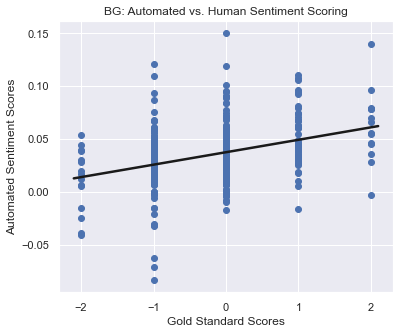

In [35]:
b, a = np.polyfit(gs_full["Annotation"], gs_full["Negscore"].astype(np.float64) / gs_full["Word_total"].astype(np.float64) , deg=1)
xseq = np.linspace(-2.1,2.1,50)

plt.scatter(gs["Annotation"], gs_full["Negscore"].astype(np.float64) / gs_full["Word_total"].astype(np.float64))
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
#plt.text(1.5, -0.03, "r = 0.40", fontsize = 12)
plt.xlabel("Gold Standard Scores")
plt.ylabel("Automated Sentiment Scores")
plt.title("BG: Automated vs. Human Sentiment Scoring")
plt.show()

In [40]:
r_regression(gs_full["Annotation"].to_numpy().reshape(-1, 1), gs_full["Sentiment_x"])

array([0.40242303])

In [39]:
gs_full.columns

Index(['Sentiment_x', 'Speech', 'Annotation', 'Note', '2nd Annot', 'Minimal',
       '2nd Minimal', 'Unnamed: 0', 'Sentiment_y', 'Word_total', 'Score',
       'Negscore', 'Title', 'Date', 'Body', 'Term', 'Session', 'Meeting',
       'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_MP',
       'Speaker_Minister', 'Speaker_party', 'Speaker_party_name',
       'Party_status', 'Speaker_name', 'Speaker_gender', 'Speaker_birth',
       'Topic_title', 'Meeting_type', 'Comission', 'YearMonth', 'Government',
       'Caretaker', 'Bloc'],
      dtype='object')